# Gépelés Tévesztés notebook

A működéshez szükség van a Setup cellák lefuttatásához.

Korpuszhoz (word_list) a MEK OSZK rész szükséges.


# Setup

In [16]:
!pip install argparse
!pip install html5lib
!pip install tqdm
!pip install ipywidgets
!pip install daft
!pip install plotly

%matplotlib inline

You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# MEK OSZK
Könyvek letöltése korpusz létrehozásához.

In [17]:
from bs4 import BeautifulSoup
import requests
import re
def get_book_by_link(link):
  page = requests.get(link)
  soup = BeautifulSoup(page.content, 'html.parser')
  text = soup.get_text()
  text = re.sub("\\n"," ", text)
  text = re.sub(r"\xa0", " ", text)
  text = re.sub(r"\r", " ", text)
  text = re.sub("[().,-?!]", " ", text)
  return(text.lower().split())

# Az ember tragédiája
word_list = get_book_by_link("http://mek.oszk.hu/00800/00849/html/01.htm#1") 

def get_book_from_mek_oszk(title):
  # Google search
  page = requests.get('https://www.google.hu/search?q=mek+oszk+'+re.sub(' ','+',title)+'+-hangoskönyv')
  soup = BeautifulSoup(page.content, 'html.parser')
  return(soup)

import numpy as np
def get_random_word(word_list):
  return(np.random.choice(word_list))

get_random_word(word_list)

'tűznek'

### Korpusz
Háború és béke, illetve Nyomorultak összes kötet.

In [18]:
import pandas as pd
# HÁBORÚ ÉS BÉKE
word_list = get_book_by_link('http://mek.oszk.hu/10800/10873/html/01.htm')
# NYOMORULTAK I.-VIII. kötet
word_list += get_book_by_link('http://mek.oszk.hu/10500/10546/html/01.htm')
word_list += get_book_by_link('http://mek.oszk.hu/10500/10546/html/02.htm')
word_list += get_book_by_link('http://mek.oszk.hu/10500/10546/html/03.htm')
word_list += get_book_by_link('http://mek.oszk.hu/10500/10546/html/04.htm')
words = pd.DataFrame(word_list, columns = ['word'])
word_table = words.word.value_counts().reset_index().rename(columns={'index': 'word', 'word': 'count'})
print('Number of different words: ',word_table.shape[0])

word_table = word_table.loc[word_table['count']>4]
print('Number of words occurring at least 5 times: ',word_table.shape[0])

Number of different words:  85294
Number of words occurring at least 5 times:  11858


# Gépelés
Elírás generatív modellje.

Generatív modell egy leírt karaktersorra:
- Veszünk egy szót a priorból (korpusz)
- A szóból kimaradhatnak betűk egy adott valószínűséggel.
- A megmaradó betűk minden karakterét leírjuk, de a leírt karakter lehet tévesztés. A tévesztés valószínűsége a billentyűzeten mért távolság szerint nő.
- A leírt betűk közé beékelődhetnek extra karakterek, melyek valószínűsége a szomszédjaiktól való távolság szerint csökken.

Formálisan:
$$P(word, message\;|\; \beta, p_{delete}, p_{extra})=P(message\;|\;word, \beta, p_{delete}, p_{extra})\cdot P(word)$$

### Grafikus modell

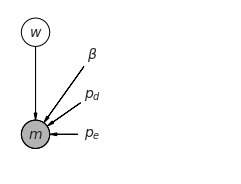

In [19]:
import daft
from matplotlib import rc
rc("font", family="serif", size=14)
pgm = daft.PGM((4, 3), origin=(0.15, 0.15))
pgm.add_node(daft.Node("m", r"$m$", 0.65, 0.9, observed=True))
pgm.add_node(daft.Node("p_e", r"$p_e$", 1.65, 0.9, observed=False, plot_params={"ec": "none"}))
pgm.add_node(daft.Node("p_d", r"$p_d$", 1.65, 1.6, observed=False, plot_params={"ec": "none"}))
pgm.add_node(daft.Node("\beta", r"$\beta$", 1.65, 2.3, observed=False, plot_params={"ec": "none"}))
pgm.add_node(daft.Node("w", r"$w$", 0.65, 2.7, observed=False))
#pgm.add_plate(daft.Plate([0.15, 0.2, 1., 2],label=r"$n$"))
pgm.add_edge("w","m")
pgm.add_edge("p_e","m")
pgm.add_edge("p_d","m")
pgm.add_edge("\beta","m")
pgm.render()

### Elütések modellje, betűtávolság

A betűtávolság jelenleg 'taxi metric' szerint van mérve. Két karakter közötti távolságot úgy kapjuk meg, hogy megnézzük összesen hányat kell lépni oldalra illetve fel-le.

Pl. i és j közötti távolság: 2

In [20]:
import random
import numpy as np

keyboard = np.array([np.array(list('123456789öüó')),list('qwertzuiopőú'), list('asdfghjkléáű'), list('íyxcvbnm,.-\'')])
print('Keyboard: ',keyboard)

def neighbours(letter):
  m = np.vstack([np.array([l == letter for l in row]) for row in keyboard])
  #return(m)
  i,j = np.where(m)
  i = i[0]
  j = j[0]
  if (i == 0):
    if (j == 0):
      keys = keyboard[0:2,0:2]
    else:
      keys = keyboard[0:2,(j-1):(j+2)]
  elif (j == 0):
    keys = keyboard[(i-1):(i+1), 0:2]
  else:
    keys = keyboard[(i-1):(i+2),(j-1):(j+2)]
  return(np.concatenate(keys))

def random_neighbour(letter):
  keys = neighbours(letter)
  p = 1/np.size(keys)
  return(random.choice(keys),p)

def distance(l1, l2):
  i1,j1 = np.where(np.vstack([np.array([l == l1 for l in row]) for row in keyboard]))
  i2,j2 = np.where(np.vstack([np.array([l == l2 for l in row]) for row in keyboard]))
  if (np.size(i1)==0) or (np.size(i2)==0):
    return(np.inf)
  return((np.abs(i1-i2)+np.abs(j1-j2))[0])

def random_letter(l, beta):
  letters = np.concatenate(keyboard)
  p = [np.exp(-beta*distance(l, k)) for k in letters]
  p /= np.sum(p)
  return(np.random.choice(letters, p = p))


print('Neighbours of i:', neighbours('i'))
print('Random key around ú: ', random_neighbour('ú'))
print('Distance between i and j:', distance('i','j'))
print('Distance between h and l:', distance('h','l'))
print('Distance between K and l:', distance('K','l'))

Keyboard:  [['1' '2' '3' '4' '5' '6' '7' '8' '9' 'ö' 'ü' 'ó']
 ['q' 'w' 'e' 'r' 't' 'z' 'u' 'i' 'o' 'p' 'ő' 'ú']
 ['a' 's' 'd' 'f' 'g' 'h' 'j' 'k' 'l' 'é' 'á' 'ű']
 ['í' 'y' 'x' 'c' 'v' 'b' 'n' 'm' ',' '.' '-' "'"]]
Neighbours of i: ['7' '8' '9' 'u' 'i' 'o' 'j' 'k' 'l']
Random key around ú:  ('ó', 0.16666666666666666)
Distance between i and j: 2
Distance between h and l: 3
Distance between K and l: inf


### 'Elírás program'

Először egy módosítás: extra betű, kihagyott betű, vagy csak a szó leírása úgy, hogy minden betűt egy másikra cserélhetünk a billentyűzeten mért távolság szerint csökkenő valószínűséggel.

Második cella: a program rekurzívan használva: vagy betűt töröl és újra módosít, vagy ad hozzá és újra módosít, vagy a kapott karaktersort leírja lehetséges tévesztésekkel

In [21]:
import random
import numpy as np
def random_modification(word, p_extra, p_delete, beta):
  choices = ['extra', 'delete', 'write']
  choice = np.random.choice(choices, p = [p_extra, p_delete, 1-p_extra-p_delete])
  if (choice == 'extra'):
    l = np.random.choice(range(len(word)))
    letter = random_letter(word[l], beta) 
    if (np.random.uniform()<0.5):
      message = word[:l]+letter+word[l:]
    else:
      message = word[:(l+1)]+letter+word[(l+1):]
  
  if (choice == 'delete'): # delete letter
    l = np.random.choice(range(len(word)))
    message = word[:l]+word[l+1:]
  
  if (choice == 'write'): # change to neighbour
    message = ''
    for c in word:
      message = message + random_letter(c, beta)
  return(message)

for i in range(10):
  print(random_modification('hogy', p_extra = 0.2, p_delete = 0.3, beta = 2))

ogy
hogí
bogy
hog
hgy
hoy
hogy
ogy
hoy
hhogy


In [22]:
def random_message(word, p_extra, p_delete, beta):
  choices = ['extra', 'delete', 'write']
  choice = np.random.choice(choices, p = [p_extra, p_delete, 1-p_extra-p_delete])
  if (choice == 'extra'):
    l = np.random.choice(range(len(word)))
    letter = random_letter(word[l], beta) 
    if (np.random.uniform()<0.5):
      message = word[:l]+letter+word[l:]
    else:
      message = word[:(l+1)]+letter+word[(l+1):]
    return(random_message(message, p_extra, p_delete, beta))
  
  if (choice == 'delete'): # delete letter
    l = np.random.choice(range(len(word)))
    message = word[:l]+word[l+1:]
    return(random_message(message, p_extra, p_delete, beta))
           
  if (choice == 'write'): # change to neighbour
    message = ''
    for c in word:
      message = message + random_letter(c, beta)
  return(message)
           
for i in range(10):
   print(random_message('alma', 0.2, 0.1, 2.5))

alms
aalm
alma
a,,q
íkma
almq
slnq
aa
a,a
alma


### Likelihood
Likelihood kiszámítása:  $P(message\;|\;word)$

Először legenerálja a szóval vagy a leírt üzenettel azonos hosszúságú hipotéziseket, majd kiszámolja, hogy mekkora az elütések likelihoodja.

Négy paramétert használ (params nevű dict-ben várja): 
  1. beta_distance: egy adott karakter $c_1$ helyett egy $c_2$-t írsz $P(write \;c_2 \;|\; want \;c_1) \sim exp(-\beta_{distance} \cdot distance(c_1,c_2))$ valószínűséggel.
  2. p_extra_letter: annak a valószínűsége, hogy a modifikáció egy extra betű
  3. p_delete_letter: annak a valószínűsége, hogy a modifikáció egy törlés
  4. limit: -- approximációra használt: azt jelenti, hogy hány betűbeli hosszeltérésig számolja ki a likelihoodokat. Pl. a default 2 azt jelenti, hogy legfeljebb 2-vel hosszabb v rövidebb szavakat vesz csak figyelembe, a többi likelihoodja 0.

In [23]:
#limit = 2

def _loglike(word, writing, beta_distance):
  assert len(word)==len(writing)
  loglike = 0
  for x, y in zip(word, writing):
    loglike += beta_distance*distance(x,y)
  return(loglike)

def likelihood(word, writing, params = dict(beta_distance = -3, p_extra_letter = -3, p_delete_letter = -4, limit = 2)):
  limit = params['limit']
  beta_distance = params['beta_distance']
  p_extra_letter = params['p_extra_letter']
  p_delete_letter = params['p_delete_letter']
  if np.abs(len(writing)-len(word))>limit:
    return(0)
  if len(writing)>len(word):    
    # GET ALL HYPOTHESES FIRST WITH WORD LENGTH
    hypotheses = [writing]
    p = [0]
    while len(hypotheses[0])>len(word):
      new_hypotheses = []
      new_p = []
      for j,hyp in enumerate(hypotheses):    
        for i in range(len(hyp)):
          if (i < (len(hyp)-1)):
              new_hypotheses.append(hyp[:i]+hyp[(i+1):])
              p_added = beta_distance*distance(hyp[i],hyp[i+1])+p_extra_letter
              new_p.append(p[j]+p_added)
          if (i > 0):
              new_hypotheses.append(hyp[:i]+hyp[(i+1):])
              p_added = beta_distance*distance(hyp[i],hyp[i-1])+p_extra_letter
              new_p.append(p[j]+p_added)
      hypotheses = new_hypotheses
      p = new_p
    
    # CALCULATE LIKELIHOOD FOR EACH HYPOTHESIS
    p_total = 0
    for i,hyp in enumerate(hypotheses):
      p_total += np.exp(_loglike(word,hyp,beta_distance)+p[i]) 
    return(p_total)
  
  if len(writing)<len(word):
    # GET ALL HYPOTHESES FIRST WITH WRITING LENGTH
    hypotheses = [word]
    p = [0]
    while len(hypotheses[0])>len(writing):
      new_hypotheses = []
      new_p = []
      for j,hyp in enumerate(hypotheses):    
        for i in range(len(hyp)):
          new_hypotheses.append(hyp[:i]+hyp[(i+1):])
          p_added = p_delete_letter
          new_p.append(p[j]+p_added)
      hypotheses = new_hypotheses
      p = new_p
    
    # CALCULATE LIKELIHOOD FOR EACH HYPOTHESIS
    p_total = 0
    for i,hyp in enumerate(hypotheses):
      p_total += np.exp(_loglike(hyp,writing,beta_distance)+p[i]) 
    return(p_total)
  
  if len(writing)==len(word):
    return(np.exp(_loglike(word,writing,beta_distance)))

print(likelihood('neki','neki'))
print(likelihood('neki','nekik')) # k közel az i-hez
print(likelihood('neki','nekid')) # d messze az i-től
print(likelihood('neki','nekidd')) # d duplázása nem csökkenti sokkal a likelihoodot
print(likelihood('neki','nek')) # betűkihagyás
print(likelihood('neki','nem')) # m közel az i-hez, k-hoz, de betűkihagyás valószínűsége kisebb, mint extra betűé

1.0
0.0027317159990725747
7.978869291736971e-10
8.339511466618207e-11
0.01922752086817664
0.0009572818960084411


### Posterior

In [24]:
#word_table = word_table.iloc[0:1000]
from tqdm import tqdm, tqdm_notebook
# Create and register a new `tqdm` instance with `pandas`
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas(tqdm_notebook())
def posterior(word_table, word, params = dict(beta_distance = -3, p_extra_letter = -3, p_delete_letter = -4, limit = 2)):
  df = word_table.copy()
  df['likelihood'] = df.progress_apply(lambda x: likelihood(x.word, word, params),
                                       axis=1)
  df['posterior'] = np.multiply(df['count'], df['likelihood'])
  df['posterior'] = df['posterior'] / np.sum(df['posterior'])
  return(df)

word = 'gojó'
word_table = posterior(word_table, word)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
100%|██████████| 11858/11858 [00:25<00:00, 473.27it/s]


### Posterior változó beta paraméter értékkel

Egy kiválasztott szűkített listára kiszámolja a posterior értékekeket különböző beta_distance értékek mellett.

In [25]:
import plotly.plotly as py
import plotly.graph_objs as go
py.sign_in('mzperix', 'IvP0JRGh6DYkUZSuEj6z')

def recalculate_posterior(word_table, word, params):
  data = []
  for p in params:
    data.append(posterior(word_table, word, p))
  return(data)

params = []
resolution = 40
for i in np.linspace(0,5,resolution):
  params.append(dict(beta_distance = -i,
                     p_extra_letter = -3,
                     p_delete_letter = -4,
                     limit = 3))
dat = recalculate_posterior(word_table.loc[word_table.posterior>1e-5],word, params)
data = [go.Bar(
              visible = False,
              x = list(df.loc[df.posterior>1e-2]['posterior']),
              y = list(df.loc[df.posterior>1e-2]['word']),
              orientation = 'h') for df in dat]
data[0]['visible'] = True

100%|██████████| 35/35 [00:00<00:00, 191.11it/s]


In [26]:
steps = []
for i in range(len(data)):
    step = dict(
        method = 'restyle',
        args = ['visible', [False] * len(data)],
    )
    step['args'][1][i] = True # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active = 1,
    currentvalue = {"prefix": "beta_distance: "},
    pad = {"t": 50},
    steps = steps
)]


# put listeners on slider activity
#left_slider.observe(on_value_change_left, names='value')
#right_slider.observe(on_value_change_right, names='value')
layout = dict(sliders=sliders)

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='beta')

### Likelihood vs. Posterior

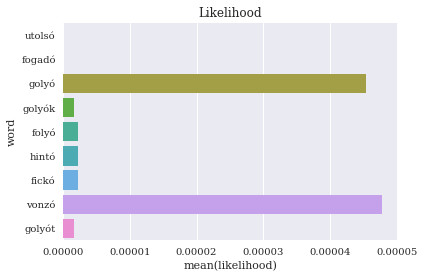

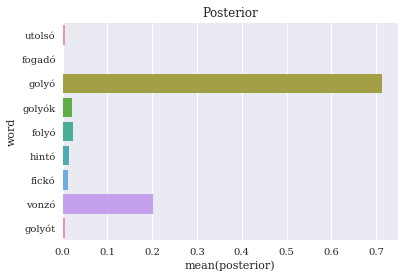

In [27]:
import seaborn
import matplotlib.pyplot as plt
seaborn.barplot(data = word_table.loc[word_table.posterior>1e-3], x = 'likelihood', y = 'word')
plt.title('Likelihood')
plt.show()
seaborn.barplot(data = word_table.loc[word_table.posterior>1e-3], x = 'posterior', y = 'word')
plt.title('Posterior')
plt.show()